In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [7]:
from pathlib import Path
import imghdr

data_dir = "C:\waste_classify\WasteClassificationNeuralNetwork\WasteImagesDataset"


img_link=list(Path(data_dir).glob(r'**/*.jpg'))

count_num=0
del_list=[]
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        del_list.append(lnk)

for lnk in del_list:
    os.remove(lnk)
print('Total %d pcs image delete from Train Dataset' % count_num)


Total 0 pcs image delete from Train Dataset


In [8]:
#LOAD DATA
DIR = "C:\waste_classify\WasteClassificationNeuralNetwork\WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7367 files belonging to 3 classes.
Using 6631 files for training.
Found 7367 files belonging to 3 classes.
Using 736 files for validation.
['Organic', 'Recycle', 'Trash']


##**Model Training**

In [9]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 20
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

Epoch 1/20


c:\Users\devin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


52/52 [==============================] - 6479s 127s/step - loss: 189.4993 - accuracy: 0.7830 - val_loss: 41.3179 - val_accuracy: 0.9321
Epoch 2/20
52/52 [==============================] - 153s 3s/step - loss: 12.3968 - accuracy: 0.8353 - val_loss: 3.4206 - val_accuracy: 0.7812
Epoch 3/20
52/52 [==============================] - 6589s 129s/step - loss: 3.0169 - accuracy: 0.7659 - val_loss: 2.8840 - val_accuracy: 0.7432
Epoch 4/20
52/52 [==============================] - 156s 3s/step - loss: 2.8660 - accuracy: 0.7898 - val_loss: 2.7995 - val_accuracy: 0.7799
Epoch 5/20
52/52 [==============================] - 7905s 3s/step - loss: 2.7990 - accuracy: 0.8334 - val_loss: 2.6858 - val_accuracy: 0.8750
Epoch 6/20
52/52 [==============================] - 148s 3s/step - loss: 2.6980 - accuracy: 0.8803 - val_loss: 2.5587 - val_accuracy: 0.9022
Epoch 7/20
52/52 [==============================] - 149s 3s/step - loss: 2.6117 - accuracy: 0.9029 - val_loss: 2.5215 - val_accuracy: 0.9076
Epoch 8/20
52

In [16]:
model.save("C:\waste_classify\WasteClassificationNeuralNetwork\model.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 128, 128, 16)         432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 128, 128, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

##**Model Evaluation**

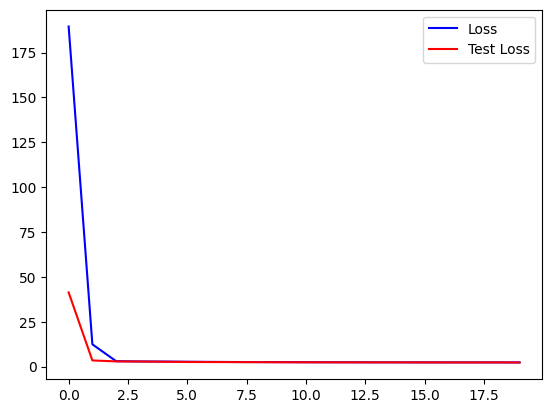

In [17]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

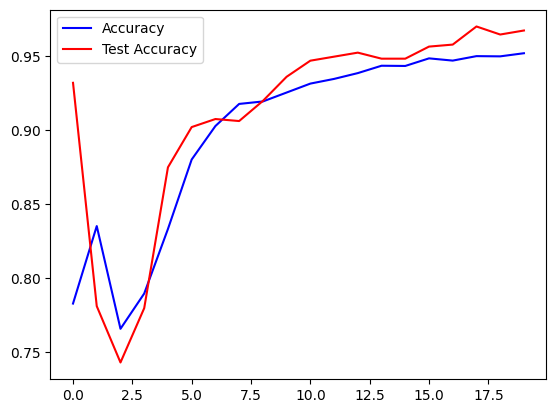

In [12]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

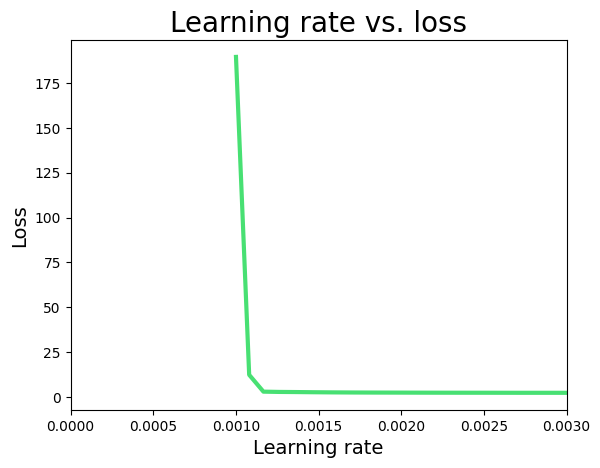

In [13]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 0s 47ms/step


<Figure size 1000x1000 with 0 Axes>

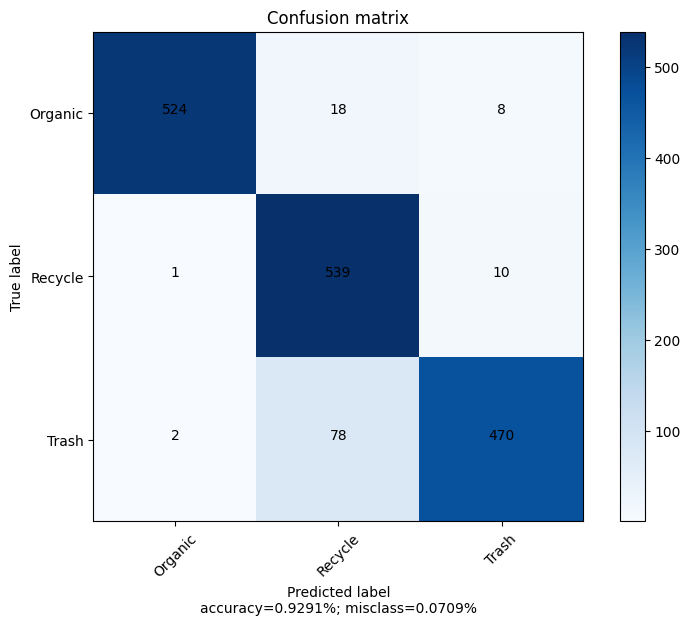

In [18]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "C:\waste_classify\WasteClassificationNeuralNetwork\WasteImagesDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

**Prediction**

In [38]:
# Prediction on Real Dataset
import tensorflow as tf
import time
curr = time.time()


model = tf.keras.models.load_model('C:\waste_classify\WasteClassificationNeuralNetwork\model.h5')

classes = ['organic', 'recyclable', 'trash']

path = "C:\waste_classify\WasteClassificationNeuralNetwork\img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")
end = time.time()
print("Time taken to find result", end-curr)

1/1 [==============================] - 2s 2s/step
[[0.04951181 0.79087585 0.15961237]]
[ 4.9511805 79.087585  15.961237 ] 
 ['organic', 'recyclable', 'trash']
Prediction:  recyclable 79.08758521080017%
Time taken to find result 6.1502368450164795


Prediction on Raspberry Pi

In [35]:
import tensorflow as tf
import time


tflite=tf.lite.Interpreter(model_path="C:\waste_classify\WasteClassificationNeuralNetwork\model.tflite")

tflite.allocate_tensors()
input_details=tflite.get_input_details()
output_details=tflite.get_output_details()
print(input_details)
print(output_details)



curr = time.time()

classes = ['organic', 'recyclable', 'trash']

path = "C:\waste_classify\WasteClassificationNeuralNetwork\img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")
end = time.time()
print("Time taken to find result", end-curr)

SyntaxError: invalid syntax (561736435.py, line 1)

Convert Tensorflow model to Tensorflow Lite

In [31]:
import tensorflow as tf
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflmodel = converter.convert()
file = open( 'model.tflite' , 'wb' ) 
file.write( tflmodel )

INFO:tensorflow:Assets written to: C:\Users\devin\AppData\Local\Temp\tmpf44bi9ar\assets


INFO:tensorflow:Assets written to: C:\Users\devin\AppData\Local\Temp\tmpf44bi9ar\assets


12881288